<a href="https://colab.research.google.com/github/akashmavle5/--akash/blob/main/Searce_k_means001.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
# import modules
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import timedelta
import os

import random
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
sns.set()

In [11]:
# load data
files_csv=[]
for dirname, _, filenames in os.walk('/content/drive/MyDrive/kaggle'):
    for filename in filenames:
        files_csv.append(os.path.join(dirname, filename))
        
# create Pandas dataframes and add the column "month"
frame=[]
for i in range(len(files_csv)):
    df_i=pd.read_csv(files_csv[i])
    df_i['month']=files_csv[i][-7:-4]
    frame.append(df_i)
df=pd.concat(frame,ignore_index=True,sort=False)

# a quick examination of the dataframe
print("The dataframe has {} rows and {} columns.\n".format(df.shape[0],df.shape[1]))
print("Shown below are the first 3 rows of the dataframe:\n")
pd.set_option('display.max_columns', 100)
display(df.head(3))

The dataframe has 20692840 rows and 10 columns.

Shown below are the first 3 rows of the dataframe:



,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,month
0,2020-02-01 00:00:01 UTC,cart,5844305,1487580006317032337,NaN,NaN,2.14,485174092,4be9643a-420b-4c6b-83dd-a15e772fbf7a,Feb
1,2020-02-01 00:00:03 UTC,view,5769925,1487580013841613016,NaN,kapous,4.22,594621622,a88baf11-9cd0-4362-bde4-1bfeed3f641d,Feb
2,2020-02-01 00:00:08 UTC,view,5817765,1487580008246412266,NaN,zeitun,11.03,495404942,3a569c8d-d848-4f09-a925-33f673d84c46,Feb


In [12]:
# data preparation

# step 1: select customers who purchased
df_sales=df.loc[df.event_type=='purchase',:]

# step 2: drop "category_code", "brand", "product_id", "category_id", and "user_session"
df_sales=df_sales.drop(columns=['category_code','brand','product_id','category_id','user_session'])

# step 3: drop duplicates
df_sales=df_sales.drop_duplicates()

# step 4: convert "event_time" to DateTime format
df_sales['event_time']=pd.to_datetime(df_sales['event_time'],infer_datetime_format=True)

nullcolumns=df_sales.isnull().sum()
nullnumbers=len(nullcolumns[nullcolumns!=0])
print("After data selection and cleansing, the dataframe has {} rows, {} columns, and {} null value.\n".format(df_sales.shape[0],df_sales.shape[1],nullnumbers))
print("Shown below are the first 3 rows of the cleaned dataframe:\n")
display(df_sales.head(3))

After data selection and cleansing, the dataframe has 908776 rows, 5 columns, and 0 null value.

Shown below are the first 3 rows of the cleaned dataframe:



,event_time,event_type,price,user_id,month
117,2020-02-01 00:08:22+00:00,purchase,2.62,278482846,Feb
118,2020-02-01 00:08:22+00:00,purchase,0.35,278482846,Feb
119,2020-02-01 00:08:22+00:00,purchase,2.14,278482846,Feb


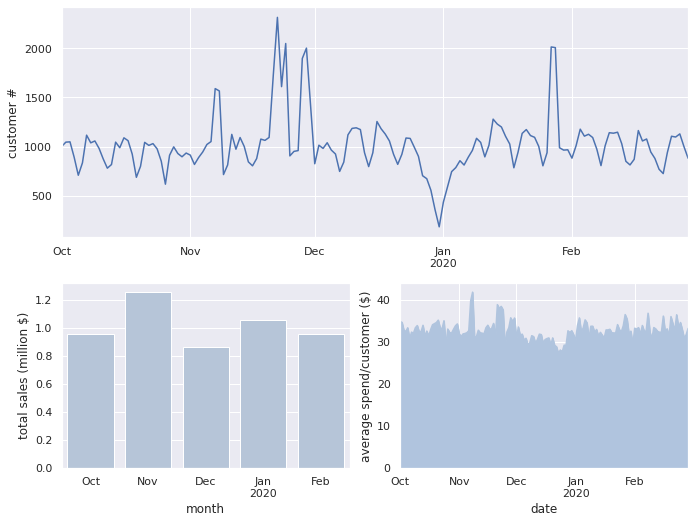

In [13]:
# initial data exploration

plt.figure(figsize=(10,8))

# plot the number of customers each day 
plt.axes([0.08, 0.4, 0.87, 0.4])
df_sales_n_user=df_sales.resample("D",on='event_time')['user_id'].nunique()
df_sales_n_user.plot(kind='line')
plt.xlabel('')
plt.ylabel('customer #')

# plot total sales/month 
plt.axes([0.08,0,0.4,0.32])
a=df_sales.resample('M',on='event_time')['price'].sum().to_frame()
a['month']=['Oct','Nov','Dec',"Jan\n2020", "Feb"]
#a['month']=["Feb"]
a['price']=a['price']/1000000
sns.barplot(x='month',y='price',data=a,color="lightsteelblue")
plt.xlabel('month')
plt.ylabel('total sales (million $)')

# plot average spend/customer
plt.axes([0.55,0,0.4,0.32])
df_sales_p_day=df_sales.resample('D',on='event_time')['price'].sum()
df_sales_spent=df_sales_p_day/df_sales_n_user
df_sales_spent.plot(kind='area',color="lightsteelblue")
plt.xlabel('date')
plt.ylabel('average spend/customer ($)');

In [14]:
# group the data by "user_id", and calcualte each customer's recency, frequency, and monetary value

# step 1: calculate "Recency", set Feb 2020 as the reference month, and use "month" as the unit
d={"Oct":4,"Nov":3,"Dec":2,"Jan":1,"Feb":0}
df_sales.loc[:,'Recency']=df_sales['month'].map(d)
df_R=df_sales.groupby('user_id')['Recency'].min().reset_index().rename(columns={"0":"Recency"})

# step 2: calculate "Frequency"
df_F=df_sales.groupby('user_id')['event_type'].count().reset_index().rename(columns={"event_type":"Frequency"})

# step 3: calculate "Monetary"
df_M=df_sales.groupby('user_id')['price'].sum().reset_index().rename(columns={"price":"Monetary"})

# step 4: merge "Recency", "Frequency", and "Monetary"
df_RF=pd.merge(df_R,df_F,on='user_id')
df_RFM=pd.merge(df_RF,df_M,on='user_id')

# step 5: remove outliers before K-Means clustering
conditions=np.abs(stats.zscore(df_RFM.loc[:,['Recency','Frequency','Monetary']]) < 3).all(axis=1)
df_RFM2=df_RFM.loc[conditions,:]

df_RFM2.head(3)

,user_id,Recency,Frequency,Monetary
0,9794320,3,2,7.72
1,10079204,3,2,25.81
2,10280338,0,19,63.29


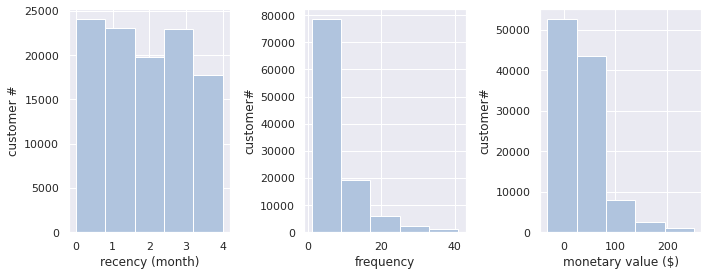

In [15]:
# visualize the distribution of "Recency", "Frequency", and "Monetary"
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(10,4))

# plot "Recency"
ax1.hist(df_RFM2['Recency'],bins=5,color='lightsteelblue')
ax1.set_xticks(np.arange(0,5,1))
ax1.set_xlabel('recency (month)')
ax1.set_ylabel('customer #')

# plot "Frequency"
ax2.hist(df_RFM2['Frequency'],bins=5,color='lightsteelblue')
ax2.set_xlabel('frequency')
ax2.set_ylabel('customer#')

# plot "Monetary"
ax3.hist(df_RFM2['Monetary'],bins=5,color='lightsteelblue')
ax3.set_xlabel('monetary value ($)')
ax3.set_ylabel('customer#')

plt.tight_layout()

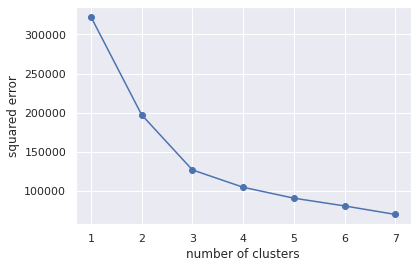

In [16]:
# k-means clustering: using recency, frequency, and monetary as clustering varaibles

# step 1: standardize data
df_RFM3=df_RFM2.drop(columns=['user_id'])
X = StandardScaler().fit_transform(df_RFM3)

# step 2: find the optimal number of clusters
SSE=[]
for i in range(1,8,1):
    kmeans=KMeans(n_clusters=i)
    kmeans.fit(X)
    SSE.append(kmeans.inertia_)
sns.set()
plt.plot(range(1,8,1),SSE,marker='o')
plt.xlabel('number of clusters')
plt.ylabel('squared error');

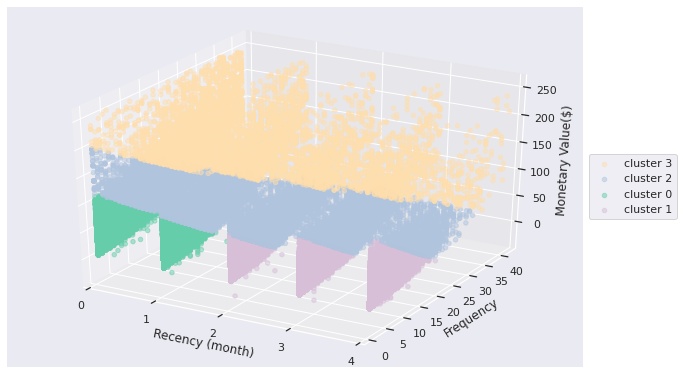

In [17]:
# k-means clustering: using recency, frequency, and monetary as clustering varaibles

# step 3: group customers into 4 clusters
random.seed(8)
km=KMeans(n_clusters=4,random_state=0)
km.fit(X)
random.seed(8)
pred=km.predict(X)
df_RFM2=df_RFM2.assign(clusters=pred)

# step 4: visualize the 4 clusters

# step 4_1: data preparation
R=[]
F=[]
M=[]
mycolors=['navajowhite','lightsteelblue','mediumaquamarine','thistle']
cluster_orders=[3,2,0,1]
for i in [0,1,2,3]:
    R.append(df_RFM2.loc[df_RFM2.clusters==cluster_orders[i],'Recency'].values.tolist())
    F.append(df_RFM2.loc[df_RFM2.clusters==cluster_orders[i],'Frequency'].values.tolist())
    M.append(df_RFM2.loc[df_RFM2.clusters==cluster_orders[i],'Monetary'].values.tolist())
    
# step 4_2: 3D scatter plot
fig=plt.figure(figsize=(8,5))
ax=Axes3D(fig)
for i in [0,1,2,3]:
    ax.scatter(R[i], F[i], M[i], c=mycolors[i], marker='o',alpha=0.5,label='cluster '+str(cluster_orders[i]))
ax.set_xlabel('Recency (month)')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary Value($)')
ax.set_xlim(0,4)
ax.set_xticks(list(range(5)))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

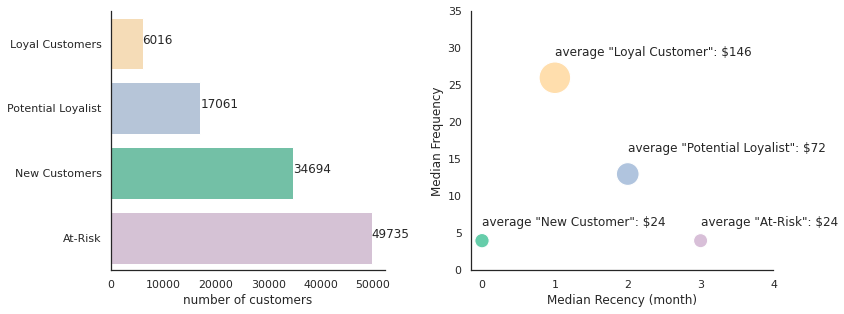

In [18]:
# replace k-means cluster names with more meaningful names
d1={0:"New Customers", 2:"Potential Loyalist", 1: "At-Risk", 3:"Loyal Customers"}
df_RFM2.loc[:,"segments"]=df_RFM2.loc[:,"clusters"].map(d1)

# calculate the number of customers, median recency, median frequency, 
# and average customer spend in each customer segment
df_RFM3=df_RFM2.groupby('segments').agg(Recency=('Recency',np.median),Frequency=('Frequency',np.median),MonetarySum=('Monetary',np.sum),size=("clusters",'size'))
df_RFM3.loc[:,'Sales/Customer']=round(df_RFM3.loc[:,'MonetarySum']/df_RFM3.loc[:,'size'])
df_RFM3=df_RFM3.astype({'Sales/Customer':int}).reset_index()

# visualize
plt.figure(figsize=(10,4))
seg_names=['Loyal Customers','Potential Loyalist','New Customers','At-Risk']

# plot the number of customers in each segment
sns.set_style("white")
plt.axes([0, 0, 0.38, 0.9])
seg=df_RFM2.groupby('segments').size().to_frame().rename(columns={0:'number of customers'}).reset_index()
sns.barplot(x='number of customers',y='segments',data=seg,order=seg_names,palette=mycolors)
for i in [0,1,2,3]:
    number=int(seg.loc[seg.segments==seg_names[i],'number of customers'])
    x_pos=round(number,-2)
    plt.text(x_pos,i,number)
plt.ylabel("")
sns.despine()

# plot recency, frequency, and average spend/customer of the 4 segments
plt.axes([0.5,0,0.42,0.9])
sns.scatterplot(x='Recency',y='Frequency',hue='segments',hue_order=seg_names,palette=mycolors,size='Sales/Customer',sizes=(200,1000),legend=False,data=df_RFM3)
plt.ylim(0,35)
plt.xticks(list(range(5)))
plt.text(1,29,'average "Loyal Customer": $146')
plt.text(2,16,'average "Potential Loyalist": $72')
plt.text(0,6,'average "New Customer": $24')
plt.text(3,6,'average "At-Risk": $24')
plt.xlabel('Median Recency (month)')
plt.ylabel('Median Frequency')
sns.despine()